# Coding

## 7.2. Convolutions for Images

### 7.2.1. The Cross-Correlation Operation

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
def corr2d(X, K):  #@save
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

In [4]:
X = torch.tensor([[0.0, 1.0, 2.0],
                  [3.0, 4.0, 5.0],
                  [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

- I understood that operation which is similar to scalar multiplication of Matrix...

### 7.2.2. Convolutional Layers

In [5]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

### 7.2.3. Object Edge Detection in Images

In [6]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [7]:
K = torch.tensor([[1.0, -1.0]])

In [8]:
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [9]:
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

### 7.2.4. Learning a Kernel

In [10]:
conv2d = nn.LazyConv2d(1, kernel_size=(1, 2), bias=False)

X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    conv2d.weight.data[:] -= lr * conv2d.weight.grad

    if (i + 1) % 2 == 0:
        print(f'epoch {i + 1}, loss {l.sum():.3f}')

epoch 2, loss 2.008
epoch 4, loss 0.497
epoch 6, loss 0.149
epoch 8, loss 0.052
epoch 10, loss 0.020


In [11]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 0.9799, -1.0081]])

## 7.3. Padding and Stride

### 7.3.1. Padding

In [12]:
import torch
from torch import nn

In [13]:
def comp_conv2d(conv2d, X):
    # (1, 1) -> batch size, the number of channels = 1
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    return Y.reshape(Y.shape[2:])

conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [14]:
conv2d = nn.LazyConv2d(1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

- If the width and height of the kernel are different, we can opt for different number of paddings for the width and height!

### 7.3.2. Stride

In [15]:
conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

In [16]:
conv2d = nn.LazyConv2d(1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

- We can stride to even two dimensions!

## 7.4. Multiple Input and Multiple Output Channels

### 7.4.1. Multiple Input Channels

In [17]:
import torch
from d2l import torch as d2l

In [18]:
def corr2d_multi_in(X, K):
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

In [19]:
X = torch.tensor(
    [[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
    [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor(
    [[[0.0, 1.0], [2.0, 3.0]],
     [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

### 7.4.2. Multiple Output Channels

In [20]:
def corr2d_multi_in_out(X, K):
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

In [21]:
K = torch.stack((K, K+1, K+2), 0)
K.shape

torch.Size([3, 2, 2, 2])

- We can make three output channels by concatenateing K, K+1, K+2 kernel tensors!

In [22]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

### 7.4.3. 1 x 1 Convolutional Layer

In [23]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    Y = torch.matmul(K, X)

    return Y.reshape((c_o, h, w))

In [24]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))
Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6

## 7.5. Pooling

In [25]:
import torch
from torch import nn
from d2l import torch as d2l

### 7.5.1. Maximum Pooling and Average Pooling

In [26]:
def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i+p_h, j: j+p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i+p_h, j: j+p_w].mean()
    return Y

In [27]:
X = torch.tensor([[0.0, 1.0, 2.0],
                  [3.0, 4.0, 5.0],
                  [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

In [28]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

### 7.5.2. Padding and Stride

In [29]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [30]:
pool2d = nn.MaxPool2d(3)
pool2d(X)

tensor([[[[10.]]]])

In [31]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [32]:
pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(0, 1))
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

### 7.5.3. Multiple Channels

In [33]:
X = torch.cat((X, X+1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

- The number of output channels are same before!

In [34]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

## 7.6. Convolutional Neural Networks (LeNet)

In [35]:
import torch
from torch import nn
from d2l import torch as d2l

### 7.6.1. LeNet

In [36]:
def init_cnn(module):  #@save
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

class LeNet(d2l.Classifier):  #@save
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

In [37]:
@d2l.add_to_class(d2l.Classifier)  #@save
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet()
model.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


### 7.6.2. Training

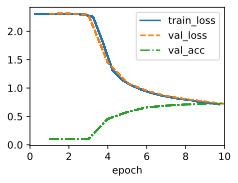

In [38]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]],
                 init_cnn)
trainer.fit(model, data)

## 8.2. Networks Using Blocks (VGG)

In [39]:
import torch
from torch import nn
from d2l import torch as d2l

### 8.2.1. VGG Blocks

In [40]:
def vgg_block(num_convs, out_channels):
    layers = []

    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels,
                                    kernel_size=3,
                                    padding=1))
        layers.append(nn.ReLU())

    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

In [41]:
class VGG(d2l.Classifier):
    def __init__(self, arch, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        conv_blks = []

        for (num_convs, out_channels) in arch:
            conv_blks.append(vgg_block(num_convs, out_channels))

        self.net = nn.Sequential(
            *conv_blks, nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

In [42]:
VGG(arch=((1, 64),
          (1, 128),
          (2, 256),
          (2, 512),
          (2, 512))).layer_summary(
    (1, 1, 224, 224))

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


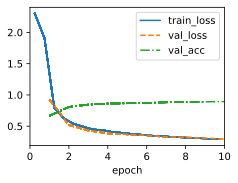

In [43]:
model = VGG(arch=((1, 16),
                  (1, 32),
                  (2, 64),
                  (2, 128),
                  (2, 128)),
            lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]],
                 d2l.init_cnn)
trainer.fit(model, data)

## 8.6. Residual Networks (ResNet) and ResNeXt

In [44]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

### 8.6.2. Residual Blocks

In [45]:
class Residual(nn.Module):  #@save
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels,
                                   kernel_size=3,
                                   padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels,
                                   kernel_size=3,
                                   padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels,
                                       kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [46]:
blk = Residual(3)
X = torch.randn(4, 3, 6, 6)
blk(X).shape

torch.Size([4, 3, 6, 6])

In [47]:
blk = Residual(6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

### 8.6.3. ResNet Model

In [48]:
class ResNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [49]:
@d2l.add_to_class(ResNet)
def block(self, num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(num_channels,
                                use_1x1conv=True,
                                strides=2))
        else:
            blk.append(Residual(num_channels))
    return nn.Sequential(*blk)

In [50]:
@d2l.add_to_class(ResNet)
def __init__(self, arch, lr=0.1, num_classes=10):
    super(ResNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, b in enumerate(arch):
        self.net.add_module(f'b{i+2}',
                            self.block(*b, first_block=(i==0)))
    self.net.add_module('last', nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

In [51]:
class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64),
                          (2, 128),
                          (2, 256),
                          (2, 512)),
                         lr,
                         num_classes)

ResNet18().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 128, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 6, 6])
Sequential output shape:	 torch.Size([1, 512, 3, 3])
Sequential output shape:	 torch.Size([1, 10])


### 8.6.4. Training

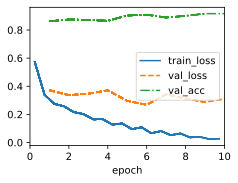

In [52]:
model = ResNet18(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]],
                 d2l.init_cnn)
trainer.fit(model, data)

# Discussions

## 7.1. From Fully Connected Layers to Convolutions

### 7.1.1. Invariance

- The CNN takes advantage of translation invariance, which means it is not related to objects' location to find or detect them!
- Then, a first layer of CNN focuses on "local regions" by only referring marginal pixels, which can represent locality!
- Using these factors, we can reduce the number of parameters without constraining the performance.

### 7.1.4. Channels

- We have to concentrate on the channels because images do not consist of two dimension, but three dimension which contains R, G, B!
- In addition, we can add another channels to the network!

## 7.2. Convolutions for Images

### 7.2.2. Convolutional Layers

- Input tensor * Kernel tensor + bias -> Output tensor...

### 7.2.4. Learning a Kernel

- We can learn the kernel tensor as well by putting inputs and output pairs!

### 7.2.5. Cross-Correlation and Convolution

- We can get the same outputs of convolution layer regardless of operating cross-correlation or convolution!

### 7.2.6. Feature Map and Receptive Field

- We can define the output of convolution layer as a feature map!
- Receptive field means that the area of input that contributes to a certain feature map!

## 7.3. Padding and Stride

### 7.3.1. Padding

- If we would like to preserve information where is at the edges or corners of image, we can introduce padding information!
- In CNN, we commonly use kernels with odd number height and width (3, 5, 7, ...) to preseve dimension while using same number of rows on top and bottom!

### 7.3.2. Stride

- To make computational efficiency or downsampling of images, we can skip pixels in the intermediate position by moving 2 or more elements at a time. We can call this method "stride"!

## 7.4. Multiple Input and Multiple Output Channels

### 7.4.1. Multiple Input Channels

- So far, we have dealt with the single input and single output channels, where we can consider the input and output tensor as matrix!
- However, if we woule like to take typical images that consist of RGB into account, we should know how to deal with multiple input and multiple output channels!

### 7.4.3. 1x1 Convolutional Layer

- We can increase nonlinearity by introducing 1x1 convolutional layer!

## 7.5. Pooling

- Pooling layers can alleviate sensitivity of location and spatially downsampling representations!
- We can easily think about pooling layers as the feature maps of feature map!

### 7.5.1. Maximum Pooling and Average Pooling

- Average pooling is very similar to image downsampling method. This method takes average value of adjacent pixels instead of choosing the value of second pixel!
- Max pooling is more preferred than average pooling method...

### 7.5.2. Padding and Stride

- As with convolutional layers, pooling layers can make padding or stride to change output shape!

### 7.5.3. Multiple Channels

- Unlike convolutional layers, pooling layers pools each input channel seperately, which means the number of output channels of pooling layer and that of input channels!

## 7.6. Convolutional Neural Networks (LeNet)

- LeNet extracts features through several convolutional layers and pooling layers!
- What if we apply LeNet to large-size images instead of 28 x 28 MNIST dataset?

## 8.2. Networks Using Blocks (VGG)

- VGG is based on simple, narrow, but deep network structure!
- VGG uses 3 x 3 filters, which is relatively small, so that we can extracts features in detail!

## 8.6. Residual Networks (ResNet) and ResNeXt

- It is not guaranteed that whenever we make CNN deeper, its perfomance is enhanced because of non-nested function classes!
- To solve this problem, we can introduce residual value (g(x) = f(x) - x)!